## Daily Arctic sea ice state 2017-2020


Sea ice extent: https://nsidc.org/data/masie

Sea ice concentration: https://seaice.uni-bremen.de/databrowser/#p=sic

Sea ice drift: ftp://osisaf.met.no/archive/ice/drift_lr/merged


In [12]:

#standard library
import os
import datetime
import time
import copy

#Raster reading and handling parts
import rasterio
import xarray as xr

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.colors as colors

from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

#conc_cmap = copy.copy(plt.cm.get_cmap('Blues_r'))
#https://colorbrewer2.org/#type=sequential&scheme=Blues&n=8
conc_cmap = colors.ListedColormap(['#084594', '#4292c6', '#9ecae1', '#f7fbff'])
boundaries = [0, 0.25, 0.5, 0.75, 1]

conc_cmap.set_bad(color=[0,0,0,0])
conc_cmap.set_under(color=[0,0,0,0])


#cartopy parts
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import numpy as np
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

#CSV io and handling
import pandas as pd


In [13]:
a=1
b=2
c=1

In [14]:
a == b == c

False

## Prepare MASIE shapefiles for plotting

In [4]:
#windows
shpfolder = "../iceextent-shapefiles/nsidc/sidads.colorado.edu/DATASETS/NOAA/G02186/shapefiles/4km/2018-20/"

#linux
#shpfolder = "../icedrift/ice-edges/sidads.colorado.edu/DATASETS/NOAA/G02186/shapefiles/4km/allyears/"

In [5]:
#assemble a list of geometries
plot_geoms = []
filenames = []
filedates = []

for f in os.listdir(shpfolder):
    if f.endswith('.shp'):
        thedate = f[18:25]
        year = int(thedate[0:4])
        day = int(thedate[4:])
        date = datetime.datetime(year,1,1)+datetime.timedelta(day -1)
        filedates.append(date.toordinal())
        
        #filedates.append(time.mktime(time.strptime(filedate[0:4] + '-' + filedate[4:6] + '-' + filedate[6:], "%Y-%m-%d")))
        #filedates.append(f[18:25])
        filenames.append(f)

In [6]:
filenames.sort(key=lambda x:int(x[18:25]))

In [7]:
filedates.sort()

In [8]:
filedates = np.array(filedates)

In [9]:
date

datetime.datetime(2019, 6, 18, 0, 0)

In [10]:
date.toordinal()

737228

In [11]:
len(filedates)

1029

...so far not sure how to include this in a cartopy plot as a subplot...

## Ingest a list of ice concentrations

Daily hDF files from the university of Bremen 

In [12]:
#windows
concfolder = "../iceconc-bremen-daily/data/"

In [13]:
#assemble a list of files, we don't ingest pixels yet
cfilenames = []
cfiledates = []

for f in os.listdir(concfolder):
    if f.endswith('.nc'):
        filedate = f[16:24]
        thedate = datetime.datetime(int(filedate[0:4]),int(filedate[4:6]),int(filedate[6:]) )
        cfiledates.append(thedate.toordinal())
        #cfiledates.append(time.mktime(time.strptime(filedate[0:4] + '-' + filedate[4:6] + '-' + filedate[6:], "%Y-%m-%d")))
        cfilenames.append(f)

In [14]:
cfilenames.sort(key=lambda x:int(x[16:24]))

In [15]:
cfiledates = np.array(cfiledates)

In [16]:
cfiledates.sort()

In [17]:
len(cfiledates)

1391

In [18]:
cfiledates

array([736330, 736331, 736332, ..., 737721, 737722, 737723])

### ingest a list of ice drift datasets

In [19]:
#windows
driftfolder = "../metno-drift/alltheyears/"

In [20]:
#assemble a list of files, we don't ingest pixels yet
dfilenames = []
dfiledates = []

for f in os.listdir(driftfolder):
    if f.endswith('.nc'):
        filedate = f[35:43]
        thedate = datetime.datetime(int(filedate[0:4]),int(filedate[4:6]),int(filedate[6:]) )
        dfiledates.append(thedate.toordinal())
        #cfiledates.append(time.mktime(time.strptime(filedate[0:4] + '-' + filedate[4:6] + '-' + filedate[6:], "%Y-%m-%d")))
        dfilenames.append(f)

In [21]:
#dfilenames = np.array(dfilenames)
#dfiledates = np.array(dfiledates)

In [22]:
dfilenames.sort(key=lambda x:int(x[35:43]))

In [23]:
dfiledates.sort()

In [24]:
dfiledates = np.array(dfiledates)

In [25]:
len(dfiledates)

1388

In [26]:
dfiledates

array([736328, 736329, 736330, ..., 737713, 737714, 737715])

In [27]:
### define a function to translate drift to mappable things...

def makedriftvectors(ds):

    lon = ds.lon.values
    lat = ds.lat.values
    
    fv = np.nan
    
    #get dX dY values
    dX = ds.dX.values[0]
    dY = ds.dY.values[0]
    
    ds.close()
    
    #get dataset shape
    vshape = np.shape(dX[0])
    
    #find nodata
    #zeroinds = np.where(dX == -998.)
    
    #set nodata to NaN
    #dX[zeroinds] = np.nan
    #dY[zeroinds] = np.nan
    
    # Convert vector from EASE2 grid to geographic (u east/v north)
    #coslon = np.cos(lon * np.pi/180) 
    #sinlon = np.sin(lon * np.pi/180) 

    #U_geo =  dX * coslon + dX * sinlon
    #V_geo = -dY * sinlon + dY * coslon  
    
    #rotate arrows to point in east/north polar stereographic...
    sourceproj = ccrs.PlateCarree()
    mapproj = ccrs.NorthPolarStereo()
    
    #ux,vx = mapproj.transform_vectors(sourceproj,lon,lat,U_geo,V_geo)
    ux,vx = mapproj.transform_vectors(sourceproj,lon,lat,dX,dY)

    #find 0 and replace with NaN
    
    zeroinds = np.where(ux == 0.)
    ux[zeroinds] = np.nan
    vx[zeroinds] = np.nan
    
    return(lon,lat,ux,vx)

In [28]:
icedriftdata = xr.open_dataset(driftfolder + '/' + dfilenames[366])

In [29]:
print(dfilenames[0])

ice_drift_nh_polstere-625_multi-oi_201612301200-201701011200.nc


In [30]:
icedriftdata.dX.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [31]:
dlon, dlat, du, dv = makedriftvectors(icedriftdata)


In [32]:
ice_speed = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

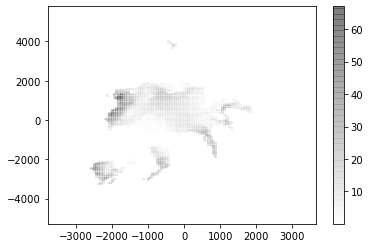

In [33]:
plt.pcolor(icedriftdata.xc.values,
                   icedriftdata.yc.values,ice_speed, cmap='gist_yarg',
                   alpha=0.3, shading='auto')
plt.colorbar()

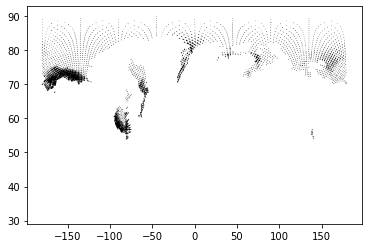

In [34]:
plt.quiver(icedriftdata.lon.values,icedriftdata.lat.values,icedriftdata.dX.values[0],icedriftdata.dY.values[0])

In [35]:
icedisplacements = pd.DataFrame(columns = ['mean', 'max', 'min', 'sd'])
allthethings = []
for f in dfilenames:
    icedriftdata = xr.open_dataset(driftfolder + '/' + f)

    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

    
    
    
    allthethings.append(np.ravel(ice_displacement))
    

In [36]:
allthethings = np.ravel(allthethings)

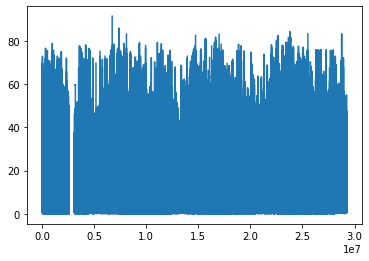

In [37]:
plt.plot(allthethings)

In [38]:
allthethings = (allthethings*1000) / (24*3600)

In [39]:
np.nanpercentile(allthethings, 2)

0.013142733142994068

In [40]:
np.nanpercentile(allthethings, 98)

0.49962404513888903

## Collect concentrations and drifts which match extents by date

In [41]:
startdate = 736330

In [42]:
commondates = set(filedates) & set(cfiledates) & set(dfiledates)

In [43]:
commondates = list(commondates)

In [44]:
commondates.sort()

In [45]:
filenames = list(filenames)

In [46]:
thefiledates = []
thefilenames = []

for date in commondates:
    dateindex = np.where(filedates == date)
    thefiledates.append(filedates[dateindex])
    thefilenames.append(filenames[dateindex[0][0]])

In [47]:
thefilenames.sort(key=lambda x:int(x[18:25]))
thefiledates.sort()

In [48]:
thefilenames[0]

'masie_ice_r00_v01_2018001_4km.shp'

In [49]:
thecfiledates = []
thecfilenames = []

for date in commondates:
    dateindex = np.where(cfiledates == date)
    thecfiledates.append(cfiledates[dateindex])
    thecfilenames.append(cfilenames[dateindex[0][0]])

In [50]:
thecfilenames.sort(key=lambda x:int(x[16:24]))
thecfiledates.sort()

In [51]:
thecfilenames[0]

'asi-AMSR2-n6250-20180101-v5.4.nc'

In [52]:
thedfiledates = []
thedfilenames = []

for date in commondates:
    dateindex = np.where(dfiledates == date)
    thedfiledates.append(dfiledates[dateindex])
    thedfilenames.append(dfilenames[dateindex[0][0]])

In [53]:
thedfilenames.sort(key=lambda x:int(x[35:43]))
thedfiledates.sort()

In [54]:
thedfilenames[0]

'ice_drift_nh_polstere-625_multi-oi_201801011200-201801031200.nc'

In [55]:
dateindex[0][0]

1387

In [56]:
thedfiledates[0]

array([736695])

In [57]:
len(thefiledates)

1018

In [58]:
thefiledates[0]

array([736695])

In [59]:
thefiledates[-1]

array([737715])

In [60]:
len(thecfiledates)

1018

In [61]:
thecfiledates[0]

array([736695])

In [62]:
thecfiledates[-1]

array([737715])

In [63]:
len(thedfiledates)

1018

In [64]:
thedfiledates[0]

array([736695])

In [65]:
thedfiledates[-1]

array([737715])

In [66]:
icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[0])

ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

plt.pcolor(icedriftdata.lon.values, 
                          icedriftdata.lat.values, 
                          ice_displacement,shading='nearest')

<ipython-input-66-3ef09a3e4dda>:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(icedriftdata.lon.values,


## prepare a geotiff basemap for plotting
https://automating-gis-processes.github.io/CSC/notebooks/L5/plotting-raster.html

Preparing a bathymetry baselayer for Cartopy. It was produced in QGIS from IBCAOv4

In [29]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [30]:
#basemapfile = '../barents-map/maplayers-utm.tiff'
basemapfile = '/mnt/stuff/ibcaov4/rendered-bathy3.tiff'


In [31]:
#gtiff = xr.open_rasterio(basemapfile)
#gtransform = Affine.from_gdal(*gtiff.attrs['transform'])

gtiff = rasterio.rasterio.open(basemapfile)

In [32]:
gtiff.bounds

BoundingBox(left=-5171538.0, bottom=-6335436.447078747, right=5240033.0, top=4084950.4470787467)

In [33]:
im = gtiff.read()

In [34]:
red = normalize(im[0])
green = normalize(im[1])
blue = normalize(im[2])

rgb = rgb = np.dstack((red, green, blue))
del im, red, green, blue

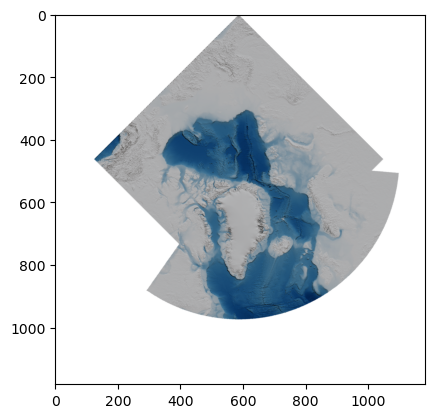

In [35]:
plt.imshow(rgb)

## Set up a land mask

...using cartopy's natural earth feature methods

In [25]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor=[1,1,1,0],
                                        facecolor=[0.9,0.9,0.9,1])

### assemble a list of sea ice geometries

In [74]:
thefilenames[0][0]

'm'

In [75]:
for f in thefilenames:
    reader = shpreader.Reader(shpfolder + '/' + f)
    plot_geoms.append(ShapelyFeature(reader.geometries(),
                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 )))


## Assemble a map!

This previews our final movie map...

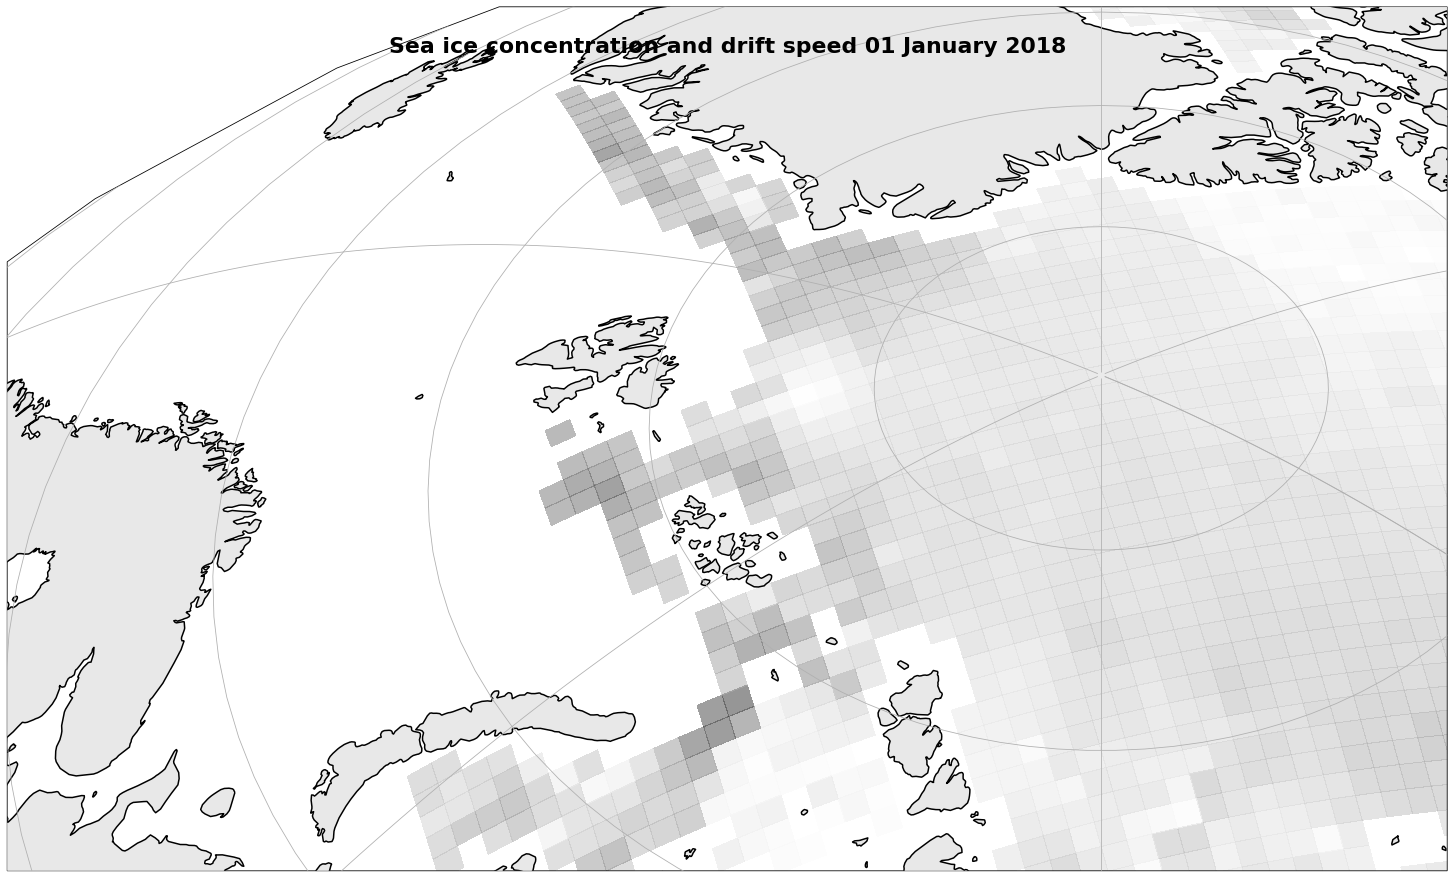

In [76]:
fig = plt.figure(figsize=(20,12))

#class cartopy.crs.NearsidePerspective(central_longitude=0.0, central_latitude=0.0, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)

#ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())

ax = fig.add_subplot(111, 
                     projection=ccrs.NearsidePerspective(central_longitude=120.0, 
                                                         central_latitude=35, 
                                                         satellite_height=60000000))

plt.gca().set_position([0, 0, 1, 1])
ax.set_aspect('auto')
ax.set_extent((-1400000, 1500000, -2400000, 200000), crs=ccrs.NorthPolarStereo())

#ax.set_extent([-10, 100, 65, 90], crs=ccrs.Geodetic())

ax.set_facecolor('#ffffff')
plotdate = datetime.date.fromordinal(thefiledates[0][0])
ax.add_feature(land_50m, zorder=1000)
ax.coastlines('50m', edgecolor=[0.8, 0.8,0.8, 0.3], linewidth=1.5, zorder=1001)
plt.pcolormesh(icedriftdata.xc.values*1000,
               icedriftdata.yc.values*1000,((ice_displacement * 1000)/(24*3600)), 
               transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), cmap='gist_yarg',
                alpha=0.5, shading='nearest', vmin = 0, vmax = 0.5)
ax.set_title('Sea ice concentration and drift speed ' + plotdate.strftime("%d %B %Y"), 
             fontsize=22, x = 0.5, y=0.94, color='black',fontweight='bold', zorder=10000)

mapgrid = ax.gridlines(draw_labels=False, zorder=10000)



In [77]:
"""
fig = plt.figure(figsize=(20,12))


#ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())


ax = fig.add_subplot(111, 
                     projection=ccrs.NearsidePerspective(central_longitude=-170.0, 
                                                         central_latitude=45, 
                                                         satellite_height=55000000))
plt.gca().set_position([0, 0, 1, 1])
ax.set_aspect('auto')


#ax.set_extent([-40, 100, 60, 90], crs=ccrs.Geodetic())
ax.set_extent((-1400000, 1500000, -2200000, 200000), crs=ccrs.NorthPolarStereo())

ax.set_facecolor('xkcd:salmon')

#plt.imshow(rgb, origin='upper', extent= [-3363851.8211, 4363851.8211,6220760.961741944,13775168.92425805], 
#           transform = ccrs.epsg(32634))

plt.imshow(rgb, origin='upper', extent= [-4502510.9113, 2938756.9129,-4571930.4898,-4571930.4898], 
           transform = ccrs.NorthPolarStereo())

for i in np.arange(1):

    reader = shpreader.Reader(shpfolder + '/' + thefilenames[i])
    plot_geom = ShapelyFeature(reader.geometries(),
                            ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 ))
    
    ax.add_feature(plot_geom, edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.2])
    
    shpdate = filedates[i]
    
    ### ice conc values
    iceconc = xr.open_dataset(concfolder + '/' + thecfilenames[i])

    cvalues = iceconc.z.values

    cshape = np.shape(cvalues)
    zeroinds = np.where(cvalues == 0.)
    cvalues[zeroinds] = np.nan
    cvalues = cvalues.reshape((cshape[0], cshape[1]))
    cvalues_m = np.ma.masked_invalid(cvalues)

    #plt.pcolor(iceconc.x.values, iceconc.y.values, cvalues_m, cmap=conc_cmap, alpha=0.3,shading='auto',
    #     transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )

    #plt.pcolormesh(iceconc.x.values, iceconc.y.values, cvalues_m, cmap=current_cmap, alpha=0.3,
    #     transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )

    plt.contourf(iceconc.x.values, iceconc.y.values, cvalues_m, cmap=conc_cmap, alpha=0.4,
         transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )

    iceconc.close()
    
    icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[i])
    
    dlon, dlat, du, dv = makedriftvectors(icedriftdata)
    
    #icedrift = ax.quiver(dlon, dlat, du, dv,
    #      transform = ccrs.PlateCarree(),
    #      regrid_shape=70, color=[0.3, 0.3, 0.3, 0.8],
    #      units='xy', angles = 'xy', pivot='mid', scale=0.0005, scale_units = 'xy')
    
    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)
    
    #to m/s: 
    ice_displacement = (ice_displacement*1000)/(24*2600)
    #plt.pcolormesh(icedriftdata.lon.values,
    #               icedriftdata.lat.values,ice_speed, transform=ccrs.PlateCarree(), cmap='gist_yarg',
    #               alpha=0.5, shading='nearest')
    
    plt.pcolormesh(icedriftdata.xc.values*1000,
                   icedriftdata.yc.values*1000, ice_displacement,
                   transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), cmap='gist_yarg',
                   alpha=0.5, shading='nearest', vmin = 0, vmax =0.5)
    
    

#ax4.quiver(np.ravel(lons), np.ravel(lats), 
#           np.ravel(u_), np.ravel(v_), transform=ccrs.PlateCarree(), regrid_shape=20,
#           pivot='mid')

plotdate = datetime.date.fromordinal(thefiledates[i][0])
ax.add_feature(land_50m, zorder=1000)
ax.coastlines('50m', edgecolor=[0.8, 0.8,0.8, 0.3], linewidth=1.5, zorder=1001)
ax.set_title('Sea ice concentration and drift speed ' + plotdate.strftime("%d %B %Y"), 
             fontsize=22, x = 0.3, y=0.08, color='black',fontweight='bold', zorder=50000)

"""

'\nfig = plt.figure(figsize=(20,12))\n\n\n#ax = fig.add_subplot(111, projection=ccrs.NorthPolarStereo())\n\n\nax = fig.add_subplot(111, \n                     projection=ccrs.NearsidePerspective(central_longitude=-170.0, \n                                                         central_latitude=45, \n                                                         satellite_height=55000000))\nplt.gca().set_position([0, 0, 1, 1])\nax.set_aspect(\'auto\')\n\n\n#ax.set_extent([-40, 100, 60, 90], crs=ccrs.Geodetic())\nax.set_extent((-1400000, 1500000, -2200000, 200000), crs=ccrs.NorthPolarStereo())\n\nax.set_facecolor(\'xkcd:salmon\')\n\n#plt.imshow(rgb, origin=\'upper\', extent= [-3363851.8211, 4363851.8211,6220760.961741944,13775168.92425805], \n#           transform = ccrs.epsg(32634))\n\nplt.imshow(rgb, origin=\'upper\', extent= [-4502510.9113, 2938756.9129,-4571930.4898,-4571930.4898], \n           transform = ccrs.NorthPolarStereo())\n\nfor i in np.arange(1):\n\n    reader = shpreader.Reade

## Set up for animations

### Base map for animation

In [78]:
aenlogo = plt.imread('./TheNansenLegacy-logo-EMBLEM-small.png')
nplogo = plt.imread('./NPI-logo-eng-small.png')


#https://matplotlib.org/examples/pylab_examples/demo_annotation_box.html
arr_img = plt.imread("./TheNansenLegacy-logo-EMBLEM.png", format='png')

In [96]:
import matplotlib.patheffects as path_effects
plt.rcParams.update({'font.size': 14,
                     'text.color': [0.6, 0.6, 0.6]})

In [36]:
gtiff.bounds

BoundingBox(left=-5171538.0, bottom=-6335436.447078747, right=5240033.0, top=4084950.4470787467)

In [37]:
bathyextent = [ gtiff.bounds[0], gtiff.bounds[2], gtiff.bounds[1], gtiff.bounds[3]]

In [43]:
fig2 = plt.figure(figsize=(20,12))
ax2 = fig2.add_subplot(111, 
                     projection=ccrs.NearsidePerspective(central_longitude=-140.0, 
                                                         central_latitude=55,
                                                         false_easting=0,
                                                         satellite_height=50000000))

#ax2 = fig2.add_subplot(111, projection=ccrs.NorthPolarStereo())
ax2.set_extent((-800000, 2200000, -2000000, 100000), crs=ccrs.NorthPolarStereo())
#ax2.set_extent([-10, 95, 65, 90], crs=ccrs.Geodetic())
plt.gca().set_position([0, 0, 1, 1])
#plt.imshow(rgb, origin='upper', extent= [-3363851.8211, 4363851.8211,6220760.961741944,13775168.92425805], 
#           transform = ccrs.epsg(32634))

plt.imshow(rgb, origin='upper', extent= bathyextent,
           transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))



ax2.add_feature(land_50m, zorder=4999)
ax2.coastlines('50m', edgecolor=[0.8, 0.8, 0.8, 0.3], linewidth=1.5, zorder=5000)
mapgrid = ax2.gridlines(draw_labels=False, zorder=10000)
mapgrid.ypadding = 30
mapgrid.xpadding = 30

ax2.text(-30, 78, 'Greenland', color='gray', size=18, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=13, zorder=20000)
ax2.text(19, 66, 'Norway', color='gray', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=17, zorder=20001)
#aenlogoplot = ax2.figure.figimage(aenlogo, 1300, 80, alpha=1, zorder=50000)

#nplogoplot = ax2.figure.figimage(nplogo, 1300, 160, alpha=1, zorder=50001)

ax2.set_aspect('auto')

In [44]:
def animate(i):

    print('making frame {}'.format(i))
    print('edge date: {}'.format(thefiledates[i]))
    print('concentration date: {}'.format(thecfiledates[i]))
    print('drift date: {}'.format(thedfiledates[i]))
    print(thedfilenames[i])
    
    iceconcs = []
    iceedges = []
    icedrifts = []
    gridlines = []
    
    # remove any existing stuff rendered on the map
    # grids
    for conc in ax2.collections:
        conc.remove()
        del conc
    
    # vectors, except for land polygons and the grid lines
    for artist in ax2.artists[2:]:
        artist.remove()
        del artist
        
    
    #reader = shpreader.Reader(shpfolder + '/' + filenames[i])
    #edge_geom = ShapelyFeature(reader.geometries(),
    #                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 ))

    iceedge = ax2.add_feature(plot_geoms[i], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.1], zorder=1)

    iceedges.append(iceedge)

    ## add concentration data - this is a bit arduous.. but saves on memory.
    iceconcdata = xr.open_dataset(concfolder + '/' + thecfilenames[i])

    xvalues = iceconcdata.x.values
    yvalues = iceconcdata.y.values
    cvalues = iceconcdata.z.values

    iceconcdata.close()

    cshape = np.shape(cvalues)
    zeroinds = np.where(cvalues == 0.)
    cvalues[zeroinds] = np.nan
    cvalues = cvalues.reshape((cshape[0], cshape[1]))
    cvalues = np.ma.masked_invalid(cvalues)

    iceconc = ax2.contourf(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.35, levels = 4,
             transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70) )

    #iceconc = ax2.pcolormesh(xvalues, yvalues, cvalues, cmap=conc_cmap, alpha=0.3,shading='auto',
    #                     transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70), zorder=1)


    iceconcs.append(iceconc)


    ## add drift data
    icedriftdata = xr.open_dataset(driftfolder + '/' + thedfilenames[i])

    ice_displacement = np.sqrt(icedriftdata.dX.values[0]**2 + icedriftdata.dY.values[0]**2)

    icedrift = ax2.pcolormesh(icedriftdata.xc.values * 1000, 
                          icedriftdata.yc.values * 1000, 
                          ((ice_displacement * 1000)/(24*3600)),
                          transform=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70),
                          alpha=0.4,
                          cmap='gist_yarg',
                          shading='nearest',
                          vmin = 0, vmax = 0.5)
    

    icedrifts.append(icedrift)
    
    # plot and title
    showgridlines = ax2.gridlines(color=[0.4, 0.4, 0.4, 0.3], draw_labels=True,
                                  x_inline=True, y_inline=True, zorder=20000)
    ax2.xlabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }
    ax2.ylabel_style = { "color": [0.2, 0.2, 0.2, 0.6] }

    plotdate = datetime.date.fromordinal(thefiledates[i][0])

    #ax2.set_title('Sea ice concentration and displacement ' + plotdate.strftime("%d %B %Y"),
    #              fontsize=22, x=0.1, y=0.95, color='#222222', fontweight='bold', zorder=50000)
    ax2.set_title(plotdate.strftime("%d %B %Y"), 
             fontsize=22, x = 0.3, y=0.05, color='black',fontweight='bold', zorder=50000)

    #ax2.figure.figimage(aenlogo, 20, 140, alpha=1)
    
    figpngfile="./pngs/nearside"+plotdate.strftime("%d-%B-%Y")+".png"
    
    fig2.savefig(figpngfile)
    
    return tuple(iceedges)+tuple(iceconcs)+tuple(icedrifts)

#write with contourf
anim = animation.FuncAnimation(fig2, animate, frames = len(thedfilenames), interval = 100, blit=False)

#write with pcolormesh
#anim = animation.FuncAnimation(fig2, animate, frames = len(plot_geoms), interval = 200, blit=False)
plt.show()

NameError: name 'thedfilenames' is not defined

In [108]:
f = './seaice-daily-velocity-more-arctic-ms-nearside3.mp4'

In [109]:
writemp4 = animation.FFMpegWriter(fps=12)

In [110]:
anim.save(f, writer=writemp4, dpi=150)

making frame 0
edge date: [736695]
concentration date: [736695]
drift date: [736695]
ice_drift_nh_polstere-625_multi-oi_201801011200-201801031200.nc
making frame 0
edge date: [736695]
concentration date: [736695]
drift date: [736695]
ice_drift_nh_polstere-625_multi-oi_201801011200-201801031200.nc
making frame 1
edge date: [736696]
concentration date: [736696]
drift date: [736696]
ice_drift_nh_polstere-625_multi-oi_201801021200-201801041200.nc
making frame 2
edge date: [736697]
concentration date: [736697]
drift date: [736697]
ice_drift_nh_polstere-625_multi-oi_201801031200-201801051200.nc
making frame 3
edge date: [736698]
concentration date: [736698]
drift date: [736698]
ice_drift_nh_polstere-625_multi-oi_201801041200-201801061200.nc
making frame 4
edge date: [736699]
concentration date: [736699]
drift date: [736699]
ice_drift_nh_polstere-625_multi-oi_201801051200-201801071200.nc
making frame 5
edge date: [736700]
concentration date: [736700]
drift date: [736700]
ice_drift_nh_polstere

making frame 54
edge date: [736749]
concentration date: [736749]
drift date: [736749]
ice_drift_nh_polstere-625_multi-oi_201802241200-201802261200.nc
making frame 55
edge date: [736750]
concentration date: [736750]
drift date: [736750]
ice_drift_nh_polstere-625_multi-oi_201802251200-201802271200.nc
making frame 56
edge date: [736751]
concentration date: [736751]
drift date: [736751]
ice_drift_nh_polstere-625_multi-oi_201802261200-201802281200.nc
making frame 57
edge date: [736752]
concentration date: [736752]
drift date: [736752]
ice_drift_nh_polstere-625_multi-oi_201802271200-201803011200.nc
making frame 58
edge date: [736753]
concentration date: [736753]
drift date: [736753]
ice_drift_nh_polstere-625_multi-oi_201802281200-201803021200.nc
making frame 59
edge date: [736754]
concentration date: [736754]
drift date: [736754]
ice_drift_nh_polstere-625_multi-oi_201803011200-201803031200.nc
making frame 60
edge date: [736755]
concentration date: [736755]
drift date: [736755]
ice_drift_nh_p

making frame 109
edge date: [736804]
concentration date: [736804]
drift date: [736804]
ice_drift_nh_polstere-625_multi-oi_201804201200-201804221200.nc
making frame 110
edge date: [736805]
concentration date: [736805]
drift date: [736805]
ice_drift_nh_polstere-625_multi-oi_201804211200-201804231200.nc
making frame 111
edge date: [736806]
concentration date: [736806]
drift date: [736806]
ice_drift_nh_polstere-625_multi-oi_201804221200-201804241200.nc
making frame 112
edge date: [736807]
concentration date: [736807]
drift date: [736807]
ice_drift_nh_polstere-625_multi-oi_201804231200-201804251200.nc
making frame 113
edge date: [736808]
concentration date: [736808]
drift date: [736808]
ice_drift_nh_polstere-625_multi-oi_201804241200-201804261200.nc
making frame 114
edge date: [736809]
concentration date: [736809]
drift date: [736809]
ice_drift_nh_polstere-625_multi-oi_201804251200-201804271200.nc
making frame 115
edge date: [736810]
concentration date: [736810]
drift date: [736810]
ice_dri

making frame 164
edge date: [736859]
concentration date: [736859]
drift date: [736859]
ice_drift_nh_polstere-625_multi-oi_201806141200-201806161200.nc
making frame 165
edge date: [736860]
concentration date: [736860]
drift date: [736860]
ice_drift_nh_polstere-625_multi-oi_201806151200-201806171200.nc
making frame 166
edge date: [736861]
concentration date: [736861]
drift date: [736861]
ice_drift_nh_polstere-625_multi-oi_201806161200-201806181200.nc
making frame 167
edge date: [736862]
concentration date: [736862]
drift date: [736862]
ice_drift_nh_polstere-625_multi-oi_201806171200-201806191200.nc
making frame 168
edge date: [736863]
concentration date: [736863]
drift date: [736863]
ice_drift_nh_polstere-625_multi-oi_201806181200-201806201200.nc
making frame 169
edge date: [736864]
concentration date: [736864]
drift date: [736864]
ice_drift_nh_polstere-625_multi-oi_201806191200-201806211200.nc
making frame 170
edge date: [736865]
concentration date: [736865]
drift date: [736865]
ice_dri

making frame 219
edge date: [736914]
concentration date: [736914]
drift date: [736914]
ice_drift_nh_polstere-625_multi-oi_201808081200-201808101200.nc
making frame 220
edge date: [736915]
concentration date: [736915]
drift date: [736915]
ice_drift_nh_polstere-625_multi-oi_201808091200-201808111200.nc
making frame 221
edge date: [736916]
concentration date: [736916]
drift date: [736916]
ice_drift_nh_polstere-625_multi-oi_201808101200-201808121200.nc
making frame 222
edge date: [736917]
concentration date: [736917]
drift date: [736917]
ice_drift_nh_polstere-625_multi-oi_201808111200-201808131200.nc
making frame 223
edge date: [736918]
concentration date: [736918]
drift date: [736918]
ice_drift_nh_polstere-625_multi-oi_201808121200-201808141200.nc
making frame 224
edge date: [736919]
concentration date: [736919]
drift date: [736919]
ice_drift_nh_polstere-625_multi-oi_201808131200-201808151200.nc
making frame 225
edge date: [736920]
concentration date: [736920]
drift date: [736920]
ice_dri

making frame 274
edge date: [736969]
concentration date: [736969]
drift date: [736969]
ice_drift_nh_polstere-625_multi-oi_201810021200-201810041200.nc
making frame 275
edge date: [736970]
concentration date: [736970]
drift date: [736970]
ice_drift_nh_polstere-625_multi-oi_201810031200-201810051200.nc
making frame 276
edge date: [736971]
concentration date: [736971]
drift date: [736971]
ice_drift_nh_polstere-625_multi-oi_201810041200-201810061200.nc
making frame 277
edge date: [736972]
concentration date: [736972]
drift date: [736972]
ice_drift_nh_polstere-625_multi-oi_201810051200-201810071200.nc
making frame 278
edge date: [736973]
concentration date: [736973]
drift date: [736973]
ice_drift_nh_polstere-625_multi-oi_201810061200-201810081200.nc
making frame 279
edge date: [736974]
concentration date: [736974]
drift date: [736974]
ice_drift_nh_polstere-625_multi-oi_201810071200-201810091200.nc
making frame 280
edge date: [736975]
concentration date: [736975]
drift date: [736975]
ice_dri

making frame 329
edge date: [737024]
concentration date: [737024]
drift date: [737024]
ice_drift_nh_polstere-625_multi-oi_201811261200-201811281200.nc
making frame 330
edge date: [737025]
concentration date: [737025]
drift date: [737025]
ice_drift_nh_polstere-625_multi-oi_201811271200-201811291200.nc
making frame 331
edge date: [737026]
concentration date: [737026]
drift date: [737026]
ice_drift_nh_polstere-625_multi-oi_201811281200-201811301200.nc
making frame 332
edge date: [737027]
concentration date: [737027]
drift date: [737027]
ice_drift_nh_polstere-625_multi-oi_201811291200-201812011200.nc
making frame 333
edge date: [737028]
concentration date: [737028]
drift date: [737028]
ice_drift_nh_polstere-625_multi-oi_201811301200-201812021200.nc
making frame 334
edge date: [737029]
concentration date: [737029]
drift date: [737029]
ice_drift_nh_polstere-625_multi-oi_201812011200-201812031200.nc
making frame 335
edge date: [737030]
concentration date: [737030]
drift date: [737030]
ice_dri

making frame 384
edge date: [737079]
concentration date: [737079]
drift date: [737079]
ice_drift_nh_polstere-625_multi-oi_201901201200-201901221200.nc
making frame 385
edge date: [737080]
concentration date: [737080]
drift date: [737080]
ice_drift_nh_polstere-625_multi-oi_201901211200-201901231200.nc
making frame 386
edge date: [737081]
concentration date: [737081]
drift date: [737081]
ice_drift_nh_polstere-625_multi-oi_201901221200-201901241200.nc
making frame 387
edge date: [737082]
concentration date: [737082]
drift date: [737082]
ice_drift_nh_polstere-625_multi-oi_201901231200-201901251200.nc
making frame 388
edge date: [737083]
concentration date: [737083]
drift date: [737083]
ice_drift_nh_polstere-625_multi-oi_201901241200-201901261200.nc
making frame 389
edge date: [737084]
concentration date: [737084]
drift date: [737084]
ice_drift_nh_polstere-625_multi-oi_201901251200-201901271200.nc
making frame 390
edge date: [737085]
concentration date: [737085]
drift date: [737085]
ice_dri

making frame 439
edge date: [737134]
concentration date: [737134]
drift date: [737134]
ice_drift_nh_polstere-625_multi-oi_201903161200-201903181200.nc
making frame 440
edge date: [737135]
concentration date: [737135]
drift date: [737135]
ice_drift_nh_polstere-625_multi-oi_201903171200-201903191200.nc
making frame 441
edge date: [737136]
concentration date: [737136]
drift date: [737136]
ice_drift_nh_polstere-625_multi-oi_201903181200-201903201200.nc
making frame 442
edge date: [737137]
concentration date: [737137]
drift date: [737137]
ice_drift_nh_polstere-625_multi-oi_201903191200-201903211200.nc
making frame 443
edge date: [737138]
concentration date: [737138]
drift date: [737138]
ice_drift_nh_polstere-625_multi-oi_201903201200-201903221200.nc
making frame 444
edge date: [737139]
concentration date: [737139]
drift date: [737139]
ice_drift_nh_polstere-625_multi-oi_201903211200-201903231200.nc
making frame 445
edge date: [737140]
concentration date: [737140]
drift date: [737140]
ice_dri

making frame 494
edge date: [737192]
concentration date: [737192]
drift date: [737192]
ice_drift_nh_polstere-625_multi-oi_201905131200-201905151200.nc
making frame 495
edge date: [737193]
concentration date: [737193]
drift date: [737193]
ice_drift_nh_polstere-625_multi-oi_201905141200-201905161200.nc
making frame 496
edge date: [737194]
concentration date: [737194]
drift date: [737194]
ice_drift_nh_polstere-625_multi-oi_201905151200-201905171200.nc
making frame 497
edge date: [737195]
concentration date: [737195]
drift date: [737195]
ice_drift_nh_polstere-625_multi-oi_201905161200-201905181200.nc
making frame 498
edge date: [737196]
concentration date: [737196]
drift date: [737196]
ice_drift_nh_polstere-625_multi-oi_201905171200-201905191200.nc
making frame 499
edge date: [737197]
concentration date: [737197]
drift date: [737197]
ice_drift_nh_polstere-625_multi-oi_201905181200-201905201200.nc
making frame 500
edge date: [737198]
concentration date: [737198]
drift date: [737198]
ice_dri

making frame 549
edge date: [737247]
concentration date: [737247]
drift date: [737247]
ice_drift_nh_polstere-625_multi-oi_201907071200-201907091200.nc
making frame 550
edge date: [737248]
concentration date: [737248]
drift date: [737248]
ice_drift_nh_polstere-625_multi-oi_201907081200-201907101200.nc
making frame 551
edge date: [737249]
concentration date: [737249]
drift date: [737249]
ice_drift_nh_polstere-625_multi-oi_201907091200-201907111200.nc
making frame 552
edge date: [737250]
concentration date: [737250]
drift date: [737250]
ice_drift_nh_polstere-625_multi-oi_201907101200-201907121200.nc
making frame 553
edge date: [737251]
concentration date: [737251]
drift date: [737251]
ice_drift_nh_polstere-625_multi-oi_201907111200-201907131200.nc
making frame 554
edge date: [737252]
concentration date: [737252]
drift date: [737252]
ice_drift_nh_polstere-625_multi-oi_201907121200-201907141200.nc
making frame 555
edge date: [737253]
concentration date: [737253]
drift date: [737253]
ice_dri

making frame 604
edge date: [737302]
concentration date: [737302]
drift date: [737302]
ice_drift_nh_polstere-625_multi-oi_201908311200-201909021200.nc
making frame 605
edge date: [737303]
concentration date: [737303]
drift date: [737303]
ice_drift_nh_polstere-625_multi-oi_201909011200-201909031200.nc
making frame 606
edge date: [737304]
concentration date: [737304]
drift date: [737304]
ice_drift_nh_polstere-625_multi-oi_201909021200-201909041200.nc
making frame 607
edge date: [737305]
concentration date: [737305]
drift date: [737305]
ice_drift_nh_polstere-625_multi-oi_201909031200-201909051200.nc
making frame 608
edge date: [737306]
concentration date: [737306]
drift date: [737306]
ice_drift_nh_polstere-625_multi-oi_201909041200-201909061200.nc
making frame 609
edge date: [737307]
concentration date: [737307]
drift date: [737307]
ice_drift_nh_polstere-625_multi-oi_201909051200-201909071200.nc
making frame 610
edge date: [737308]
concentration date: [737308]
drift date: [737308]
ice_dri

making frame 659
edge date: [737357]
concentration date: [737357]
drift date: [737357]
ice_drift_nh_polstere-625_multi-oi_201910251200-201910271200.nc
making frame 660
edge date: [737358]
concentration date: [737358]
drift date: [737358]
ice_drift_nh_polstere-625_multi-oi_201910261200-201910281200.nc
making frame 661
edge date: [737359]
concentration date: [737359]
drift date: [737359]
ice_drift_nh_polstere-625_multi-oi_201910271200-201910291200.nc
making frame 662
edge date: [737360]
concentration date: [737360]
drift date: [737360]
ice_drift_nh_polstere-625_multi-oi_201910281200-201910301200.nc
making frame 663
edge date: [737361]
concentration date: [737361]
drift date: [737361]
ice_drift_nh_polstere-625_multi-oi_201910291200-201910311200.nc
making frame 664
edge date: [737362]
concentration date: [737362]
drift date: [737362]
ice_drift_nh_polstere-625_multi-oi_201910301200-201911011200.nc
making frame 665
edge date: [737363]
concentration date: [737363]
drift date: [737363]
ice_dri

making frame 714
edge date: [737412]
concentration date: [737412]
drift date: [737412]
ice_drift_nh_polstere-625_multi-oi_201912191200-201912211200.nc
making frame 715
edge date: [737413]
concentration date: [737413]
drift date: [737413]
ice_drift_nh_polstere-625_multi-oi_201912201200-201912221200.nc
making frame 716
edge date: [737414]
concentration date: [737414]
drift date: [737414]
ice_drift_nh_polstere-625_multi-oi_201912211200-201912231200.nc
making frame 717
edge date: [737415]
concentration date: [737415]
drift date: [737415]
ice_drift_nh_polstere-625_multi-oi_201912221200-201912241200.nc
making frame 718
edge date: [737416]
concentration date: [737416]
drift date: [737416]
ice_drift_nh_polstere-625_multi-oi_201912231200-201912251200.nc
making frame 719
edge date: [737417]
concentration date: [737417]
drift date: [737417]
ice_drift_nh_polstere-625_multi-oi_201912241200-201912261200.nc
making frame 720
edge date: [737418]
concentration date: [737418]
drift date: [737418]
ice_dri

making frame 769
edge date: [737467]
concentration date: [737467]
drift date: [737467]
ice_drift_nh_polstere-625_multi-oi_202002121200-202002141200.nc
making frame 770
edge date: [737468]
concentration date: [737468]
drift date: [737468]
ice_drift_nh_polstere-625_multi-oi_202002131200-202002151200.nc
making frame 771
edge date: [737469]
concentration date: [737469]
drift date: [737469]
ice_drift_nh_polstere-625_multi-oi_202002141200-202002161200.nc
making frame 772
edge date: [737470]
concentration date: [737470]
drift date: [737470]
ice_drift_nh_polstere-625_multi-oi_202002151200-202002171200.nc
making frame 773
edge date: [737471]
concentration date: [737471]
drift date: [737471]
ice_drift_nh_polstere-625_multi-oi_202002161200-202002181200.nc
making frame 774
edge date: [737472]
concentration date: [737472]
drift date: [737472]
ice_drift_nh_polstere-625_multi-oi_202002171200-202002191200.nc
making frame 775
edge date: [737473]
concentration date: [737473]
drift date: [737473]
ice_dri

making frame 824
edge date: [737522]
concentration date: [737522]
drift date: [737522]
ice_drift_nh_polstere-625_multi-oi_202004071200-202004091200.nc
making frame 825
edge date: [737523]
concentration date: [737523]
drift date: [737523]
ice_drift_nh_polstere-625_multi-oi_202004081200-202004101200.nc
making frame 826
edge date: [737524]
concentration date: [737524]
drift date: [737524]
ice_drift_nh_polstere-625_multi-oi_202004091200-202004111200.nc
making frame 827
edge date: [737525]
concentration date: [737525]
drift date: [737525]
ice_drift_nh_polstere-625_multi-oi_202004101200-202004121200.nc
making frame 828
edge date: [737526]
concentration date: [737526]
drift date: [737526]
ice_drift_nh_polstere-625_multi-oi_202004111200-202004131200.nc
making frame 829
edge date: [737527]
concentration date: [737527]
drift date: [737527]
ice_drift_nh_polstere-625_multi-oi_202004121200-202004141200.nc
making frame 830
edge date: [737528]
concentration date: [737528]
drift date: [737528]
ice_dri

making frame 879
edge date: [737577]
concentration date: [737577]
drift date: [737577]
ice_drift_nh_polstere-625_multi-oi_202006011200-202006031200.nc
making frame 880
edge date: [737578]
concentration date: [737578]
drift date: [737578]
ice_drift_nh_polstere-625_multi-oi_202006021200-202006041200.nc
making frame 881
edge date: [737579]
concentration date: [737579]
drift date: [737579]
ice_drift_nh_polstere-625_multi-oi_202006031200-202006051200.nc
making frame 882
edge date: [737580]
concentration date: [737580]
drift date: [737580]
ice_drift_nh_polstere-625_multi-oi_202006041200-202006061200.nc
making frame 883
edge date: [737581]
concentration date: [737581]
drift date: [737581]
ice_drift_nh_polstere-625_multi-oi_202006051200-202006071200.nc
making frame 884
edge date: [737582]
concentration date: [737582]
drift date: [737582]
ice_drift_nh_polstere-625_multi-oi_202006061200-202006081200.nc
making frame 885
edge date: [737583]
concentration date: [737583]
drift date: [737583]
ice_dri

making frame 934
edge date: [737632]
concentration date: [737632]
drift date: [737632]
ice_drift_nh_polstere-625_multi-oi_202007261200-202007281200.nc
making frame 935
edge date: [737633]
concentration date: [737633]
drift date: [737633]
ice_drift_nh_polstere-625_multi-oi_202007271200-202007291200.nc
making frame 936
edge date: [737634]
concentration date: [737634]
drift date: [737634]
ice_drift_nh_polstere-625_multi-oi_202007281200-202007301200.nc
making frame 937
edge date: [737635]
concentration date: [737635]
drift date: [737635]
ice_drift_nh_polstere-625_multi-oi_202007291200-202007311200.nc
making frame 938
edge date: [737636]
concentration date: [737636]
drift date: [737636]
ice_drift_nh_polstere-625_multi-oi_202007301200-202008011200.nc
making frame 939
edge date: [737637]
concentration date: [737637]
drift date: [737637]
ice_drift_nh_polstere-625_multi-oi_202007311200-202008021200.nc
making frame 940
edge date: [737638]
concentration date: [737638]
drift date: [737638]
ice_dri

making frame 989
edge date: [737687]
concentration date: [737687]
drift date: [737687]
ice_drift_nh_polstere-625_multi-oi_202009191200-202009211200.nc
making frame 990
edge date: [737688]
concentration date: [737688]
drift date: [737688]
ice_drift_nh_polstere-625_multi-oi_202009201200-202009221200.nc
making frame 991
edge date: [737689]
concentration date: [737689]
drift date: [737689]
ice_drift_nh_polstere-625_multi-oi_202009211200-202009231200.nc
making frame 992
edge date: [737690]
concentration date: [737690]
drift date: [737690]
ice_drift_nh_polstere-625_multi-oi_202009221200-202009241200.nc
making frame 993
edge date: [737691]
concentration date: [737691]
drift date: [737691]
ice_drift_nh_polstere-625_multi-oi_202009231200-202009251200.nc
making frame 994
edge date: [737692]
concentration date: [737692]
drift date: [737692]
ice_drift_nh_polstere-625_multi-oi_202009241200-202009261200.nc
making frame 995
edge date: [737693]
concentration date: [737693]
drift date: [737693]
ice_dri

In [10]:
fig2

NameError: name 'fig2' is not defined

A little test

In [1]:
array1 = ["a1", "b1", "c1"]
array2 = ["a2", "b2", "c2"]
array3 = ["a3", "b3", "c3"]

In [87]:
def mapit_parallel(*args):
    print(args)
    
    i = args[0]
    array1 = args[1]
    array2 = args[2]
    array3 = args[3]
    print(i)
    
    fig3 = plt.figure(figsize=(20,12))
    ax3 = fig3.add_subplot(111, 
                         projection=ccrs.NearsidePerspective(central_longitude=-140.0, 
                                                             central_latitude=55,
                                                             false_easting=0,
                                                             satellite_height=50000000))
    
    #ax2 = fig2.add_subplot(111, projection=ccrs.NorthPolarStereo())
    ax3.set_extent((-800000, 2200000, -2000000, 100000), crs=ccrs.NorthPolarStereo())
    #ax2.set_extent([-10, 95, 65, 90], crs=ccrs.Geodetic())
    plt.gca().set_position([0, 0, 1, 1])
    #plt.imshow(rgb, origin='upper', extent= [-3363851.8211, 4363851.8211,6220760.961741944,13775168.92425805], 
    #           transform = ccrs.epsg(32634))
    
    plt.imshow(rgb, origin='upper', extent= bathyextent,
               transform = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
    
    
    
    ax3.add_feature(land_50m, zorder=4999)
    ax3.coastlines('50m', edgecolor=[0.8, 0.8, 0.8, 0.3], linewidth=1.5, zorder=5000)
    mapgrid = ax3.gridlines(draw_labels=False, zorder=10000)
    mapgrid.ypadding = 30
    mapgrid.xpadding = 30
    
    #ax3.text(-30, 78, 'Greenland', color='gray', size=18, ha='center', va='center', transform=ccrs.PlateCarree(),
    #         rotation=13, zorder=20000)
    #ax3.text(19, 66, 'Norway', color='gray', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),
    #         rotation=17, zorder=20001)
    #aenlogoplot = ax2.figure.figimage(aenlogo, 1300, 80, alpha=1, zorder=50000)
    
    #nplogoplot = ax2.figure.figimage(nplogo, 1300, 160, alpha=1, zorder=50001)
    
    ax3.set_aspect('auto')
    

    ax3.text(-30, 78, array1[i], color='gray', size=18, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=13, zorder=20000)
    ax3.text(19, 66, array2[i], color='gray', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=17, zorder=20001)
    ax3.text(19, 86, array3[i], color='gray', size=20, ha='center', va='center', transform=ccrs.PlateCarree(),
         rotation=17, zorder=20002)

    figpngfile="./test"+str(i)+".png"
    
    fig3.savefig(figpngfile)
    

In [79]:
#blasting out map frames:
import multiprocessing as mp


In [80]:
processes = [mp.Process(target=mapit_parallel, args=(i, array1, array2, array3)) for i in range(3)]

In [81]:
for process in processes:
    process.start()
for process in processes:
    process.join()
print('Done', flush=True)

0
1
2
Done


In [88]:
pool = mp.Pool(3)

([0, 1, 2],)(['a1', 'b1', 'c1'],)(['a2', 'b2', 'c2'],)


(['a3', 'b3', 'c3'],)
(0, 1, 2)('a1', 'b1', 'c1')('a2', 'b2', 'c2')


('a3', 'b3', 'c3')
('a1', 'b1', 'c1')(0, 1, 2)('a2', 'b2', 'c2')


('a3', 'b3', 'c3')


In [91]:
pool.starmap(mapit_parallel, [range(3), array1, array2, array3])

IndexError: tuple index out of range